In [1]:
import osmnx as ox
import networkx as nx
# import pandas as pd
# import numpy as np
from geopy.distance import great_circle
from heapq import heappop, heappush
from itertools import count
import matplotlib.pyplot as plt


from networkx.algorithms.shortest_paths.weighted import _weight_function

import sys
sys.path.append('../../../Multimodal_freight_USA/')

from mfreight.utils import plot
from mfreight.Multimodal.graph_utils import MultimodalNet

In [2]:
Net = MultimodalNet(path_u="../../../Multimodal_freight_USA/mfreight/Multimodal/data/multimodal_G_tot_u_w_price.plk")

# Astar

In [19]:
def heuristic_func_co2(u,v, G=Net.G_multimodal_u):
    return great_circle((G.nodes[u]['y'],G.nodes[u]['x']),
                       (G.nodes[v]['y'],G.nodes[v]['x'])).miles * 0.01213


def astar_path(G, source, target, heuristic=None, weight="weight", capture_list=[None], save=False, show=False):
    """Modified Astar. 
    Enter a capture_list to show the nodes explorations for the defined Dijkstra rank of the algorithm.
    """
    if source not in G or target not in G:
        msg = f"Either source {source} or target {target} is not in G"
        raise nx.NodeNotFound(msg)

    if heuristic is None:
        def heuristic(u, v):
            return 0

    push = heappush
    pop = heappop
    weight = _weight_function(G, weight)

    c = count()
    queue = [(0, next(c), source, 0, None)]

    enqueued = {}
    explored = {}
    
    counter = 0

    while queue:
        _, rank, curnode, dist, parent = pop(queue)

        if curnode == target:
            path = [curnode]
            node = parent
            while node is not None:
                path.append(node)
                node = explored[node]
            path.reverse()
            if capture_list:
                orig=G.nodes[source]['geometry']
                dest=G.nodes[target]['geometry']
                if save:
                    plot.plot_multimodal_path_search(G.subgraph(explored.keys()), orig=orig, dest=dest, save_path=f'Images/Astar{counter}',show=show)
                    remaining=[i for i in capture_list if i>counter]
                    print(remaining)
                    for i in remaining:
                        print(i)
                        plot.plot_multimodal_route(G, orig=orig, dest=dest, save_path=f'Images/Astar{i}', route=path, show=show)
                else:
                    plot.plot_multimodal_path_search(G.subgraph(explored.keys()), orig=orig, dest=dest, save_path=f'Images/Astar{counter}',show=show)
                    plot.plot_multimodal_route(G, orig=orig, dest=dest, save_path=None, route=path, show=show)
            return path, explored

        if curnode in explored:
            # Do not override the parent of starting node
            if explored[curnode] is None:
                continue

            # Skip bad paths that were enqueued before finding a better one
            qcost, h = enqueued[curnode]
            if qcost < dist:
                continue

        explored[curnode] = parent
        counter += 1
        
        # Generate plots
        if counter in capture_list:
            print(f'Subgraph_nodes: {len(G.subgraph(explored.keys()))}')
            orig=G.nodes[source]['geometry']
            dest=G.nodes[target]['geometry']
            if save:
                plot.plot_multimodal_path_search(G.subgraph(explored.keys()), orig=orig, dest=dest, save_path=f'Images/Astar{counter}',show=show)
            else:
                plot.plot_multimodal_path_search(G.subgraph(explored.keys()), orig=orig, dest=dest, save_path=None, show=show)

        for neighbor, w in G[curnode].items():
            ncost = dist + weight(curnode, neighbor, w)
            if neighbor in enqueued:
                qcost, h = enqueued[neighbor]
                if qcost <= ncost:
                    continue
            else:
                h = heuristic(neighbor, target)
            enqueued[neighbor] = ncost, h
            push(queue, (ncost + h, next(c), neighbor, ncost, curnode))

    raise nx.NetworkXNoPath(f"Node {target} not reachable from {source}")

# Bidirectional Dijkstra

In [4]:
from networkx.algorithms.shortest_paths.weighted import _weight_function

def bidirectionnal_dijkstra(G, source, target, weight="weight", save=False, capture_list=None, show=False):

    if source not in G or target not in G:
        msg = f"Either source {source} or target {target} is not in G"
        raise nx.NodeNotFound(msg)

    if source == target:
        return (0, [source])

    weight = _weight_function(G, weight)
    push = heappush
    pop = heappop
    # Init:  [Forward, Backward]
    dists = [{}, {}]  # dictionary of final distances
    paths = [{source: [source]}, {target: [target]}]  # dictionary of paths
    fringe = [[], []]  # heap of (distance, node) for choosing node to expand
    seen = [{source: 0}, {target: 0}]  # dict of distances to seen nodes
    c = count()
    counter=0
    # initialize fringe heap
    push(fringe[0], (0, next(c), source))
    push(fringe[1], (0, next(c), target))
    # neighs for extracting correct neighbor information
    if G.is_directed():
        neighs = [G._succ, G._pred]
    else:
        neighs = [G._adj, G._adj]
    # variables to hold shortest discovered path
    # finaldist = 1e30000
    finalpath = []
    dir = 1
    while fringe[0] and fringe[1]:
        counter+=1
        # choose direction
        # dir == 0 is forward direction and dir == 1 is back
        dir = 1 - dir
        # extract closest to expand
        (dist, rank, v) = pop(fringe[dir])
        if v in dists[dir]:
            # Shortest path to v has already been found
            continue
        # update distance
        dists[dir][v] = dist  # equal to seen[dir][v]
        if v in dists[1 - dir]:
            # if we have scanned v in both directions we are done
            # we have now discovered the shortest path
            if capture_list:
                orig=G.nodes[source]['geometry']
                dest=G.nodes[target]['geometry']
                if save:
                    explored = list(seen[0].keys())
                    explored.extend(list(seen[1].keys()))
                    plot.plot_multimodal_path_search(G.subgraph(explored), orig=orig, dest=dest, save_path=f'Images/BiDijkstra{counter}',show=show)
                    remaining=[i for i in capture_list if i>counter]
                    for i in remaining:
                        plot.plot_multimodal_route(G, orig=orig, dest=dest, save_path=f'Images/BiDijkstra{i}', route=path, show=show)
                else:
                    plot.plot_multimodal_route(G, orig=orig, dest=dest, save_path=None, route=path, show=show)
            return (finalpath, finaldist, rank)
        
        if counter in capture_list:
            explored = list(seen[0].keys())
            explored.extend(list(seen[1].keys()))
            print(f'Subgraph_nodes: {len(G.subgraph(explored))}')
            orig=G.nodes[source]['geometry']
            dest=G.nodes[target]['geometry']
            if save:
                plot.plot_multimodal_path_search(G.subgraph(explored), orig=orig, dest=dest, save_path=f'Images/BiDijkstra{counter}',show=show)
            else:
                plot.plot_multimodal_path_search(G.subgraph(explored), orig=orig, dest=dest, save_path=None, show=show)

        for w, d in neighs[dir][v].items():
            if dir == 0:  # forward
                vwLength = dists[dir][v] + weight(v, w, d)
            else:  # back, must remember to change v,w->w,v
                vwLength = dists[dir][v] + weight(w, v, d)
            if w in dists[dir]:
                if vwLength < dists[dir][w]:
                    raise ValueError("Contradictory paths found: negative weights?")
            elif w not in seen[dir] or vwLength < seen[dir][w]:
                # relaxing
                seen[dir][w] = vwLength
                push(fringe[dir], (vwLength, next(c), w))
                paths[dir][w] = paths[dir][v] + [w]
                if w in seen[0] and w in seen[1]:
                    # see if this path is better than than the already
                    # discovered shortest path
                    totaldist = seen[0][w] + seen[1][w]
                    if finalpath == [] or finaldist > totaldist:
                        finaldist = totaldist
                        revpath = paths[1][w][:]
                        revpath.reverse()
                        finalpath = paths[0][w] + revpath[1:]
    raise nx.NetworkXNoPath(f"No path between {source} and {target}.")

# Dijkstra

In [18]:
def dijkstra(
    G, source, weight_str, pred=None, paths=None, cutoff=None, target=None, save=False, capture_list=None, show=False
):

    G_succ = G._succ if G.is_directed() else G._adj

    weight = lambda u, v, data: data.get(weight_str, 1)
    counter=0
    
    if paths is None:
        paths={source:[source]}
        

    push = heappush
    pop = heappop
    dist = {}  # dictionary of final distances
    seen = {}
    # fringe is heapq with 3-tuples (distance,c,node)
    # use the count c to avoid comparing nodes (may not be able to)
    c = count()
    fringe = []

    if source not in G:
        raise nx.NodeNotFound(f"Source {source} not in G")
    seen[source] = 0
    push(fringe, (0, next(c), source))
    while fringe:
        counter+=1
        (d, rank, v) = pop(fringe)
        if v in dist:
            continue  # already searched this node.
        dist[v] = d
        if v == target:
            break
            
        if counter in capture_list:
            
            orig=G.nodes[source]['geometry']
            dest=G.nodes[target]['geometry']
            explored = list(seen.keys())
            print(f'Subgraph_nodes: {len(G.subgraph(explored))}')
            
            if save:
                plot.plot_multimodal_path_search(G.subgraph(explored), orig=orig, dest=dest, save_path=f'Images/Dijkstra{counter}',show=show)
            else:
                plot.plot_multimodal_path_search(G.subgraph(explored), orig=orig, dest=dest, save_path=None, show=show)
                
        for u, e in G_succ[v].items():
            cost = weight(v, u, e)
            if cost is None:
                continue
            vu_dist = dist[v] + cost
            if cutoff is not None:
                if vu_dist > cutoff:
                    continue
            if u in dist:
                u_dist = dist[u]
                if vu_dist < u_dist:
                    raise ValueError("Contradictory paths found:", "negative weights?")
                elif pred is not None and vu_dist == u_dist:
                    pred[u].append(v)
            elif u not in seen or vu_dist < seen[u]:
                seen[u] = vu_dist
                push(fringe, (vu_dist, next(c), u))
                if paths is not None:
                    paths[u] = paths[v] + [u]
                if pred is not None:
                    pred[u] = [v]
            elif vu_dist == seen[u]:
                if pred is not None:
                    pred[u].append(v)

    # The optional predecessor and path dictionaries can be accessed
    # by the caller via the pred and paths objects passed as arguments.
    
    if capture_list:
        orig=G.nodes[source]['geometry']
        dest=G.nodes[target]['geometry']
        if save:
            explored = list(seen.keys())
            print(f'Subgraph_nodes_end: {len(G.subgraph(explored))}')
            plot.plot_multimodal_path_search(G.subgraph(explored), orig=orig, dest=dest, save_path=f'Images/Dijkstra{counter}',show=show)
            remaining=[i for i in capture_list if i>counter]
            print(remaining)
            for i in remaining:
                print(i)
                plot.plot_multimodal_route(G, orig=orig, dest=dest, save_path=f'Images/Dijkstra{i}', route=path, show=show)
        else:
            plot.plot_multimodal_route(G, orig=orig, dest=dest, save_path=None, route=path, show=show)
    return paths[target], dist, rank

# Run simulations

In [22]:
orig = (35.122246, -80.819619) # Charlotte
dest = (38.499301, -104.677064) # Denver

node_orig = ox.get_nearest_node(Net.G_reachable_nodes, orig, method="haversine", return_dist=False)
node_dest = ox.get_nearest_node(Net.G_reachable_nodes, dest, method="haversine", return_dist=False)
capture_list=list(range(0,44600,500))#[0,500,2000,10000, 100000, 200000]#
capture_list[0]=2
target="CO2_eq_kg"

Subgraph_nodes: 2
Subgraph_nodes: 500
Subgraph_nodes: 2000
Subgraph_nodes: 9988
[100000, 200000]
100000
200000


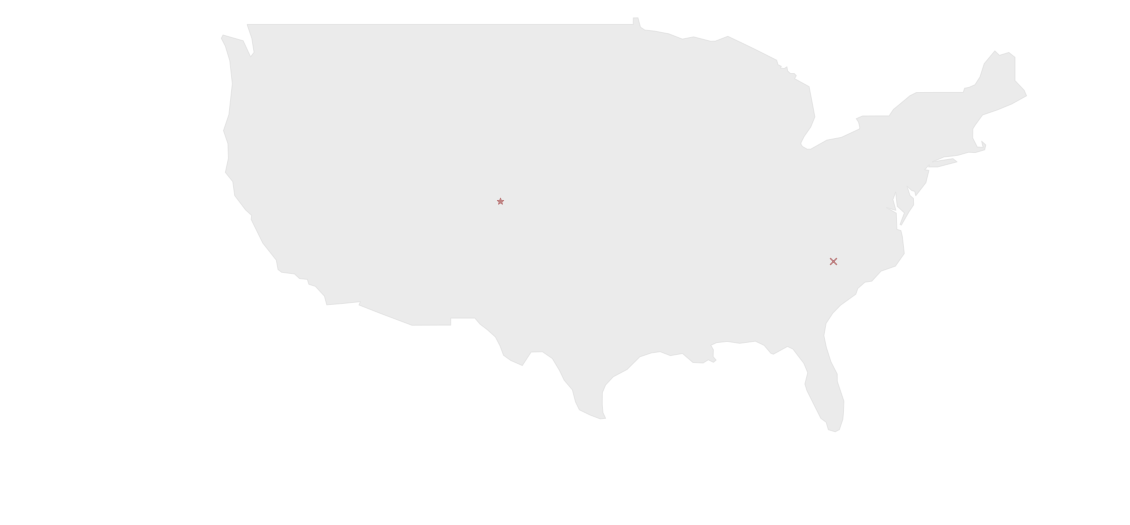

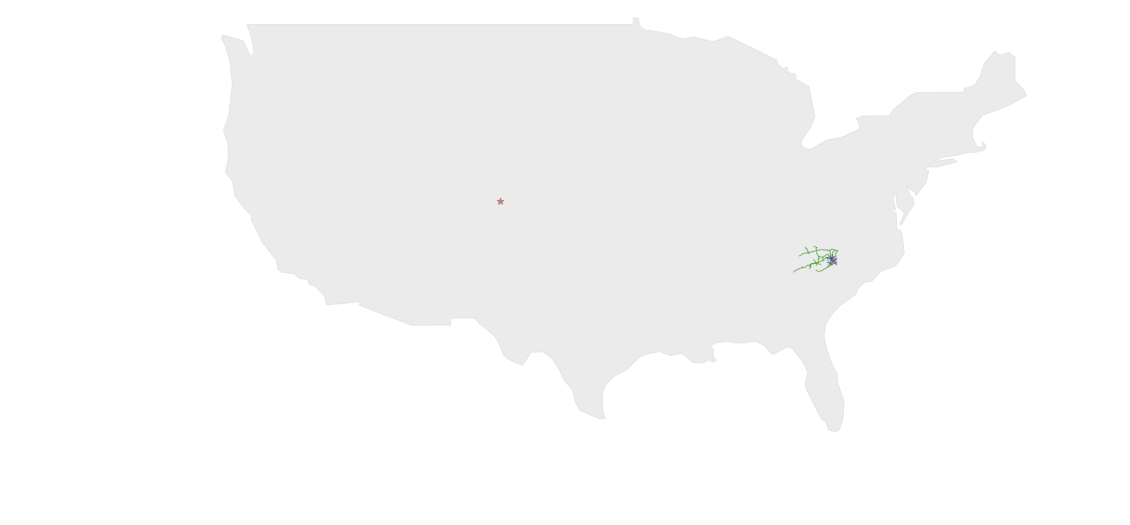

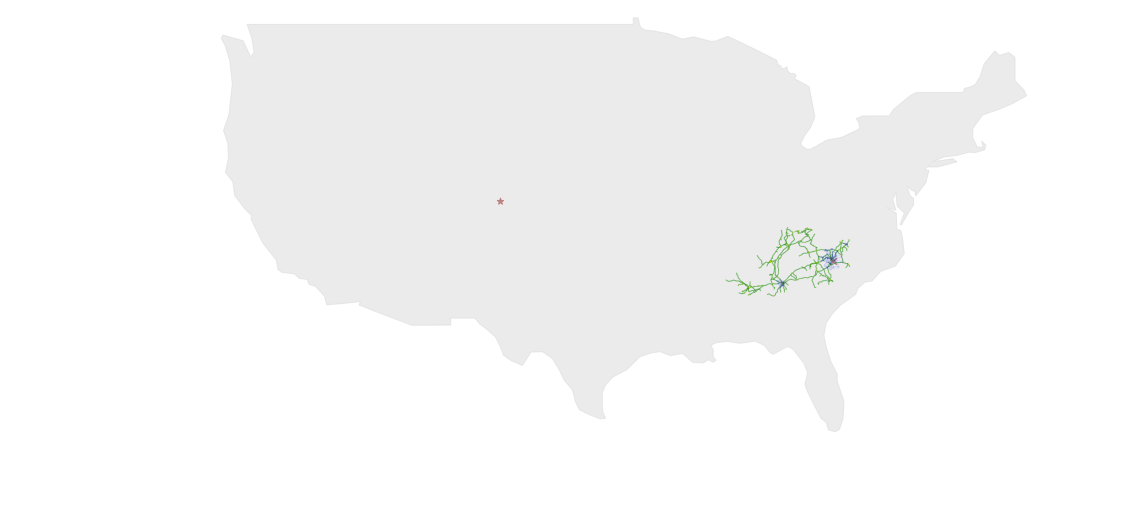

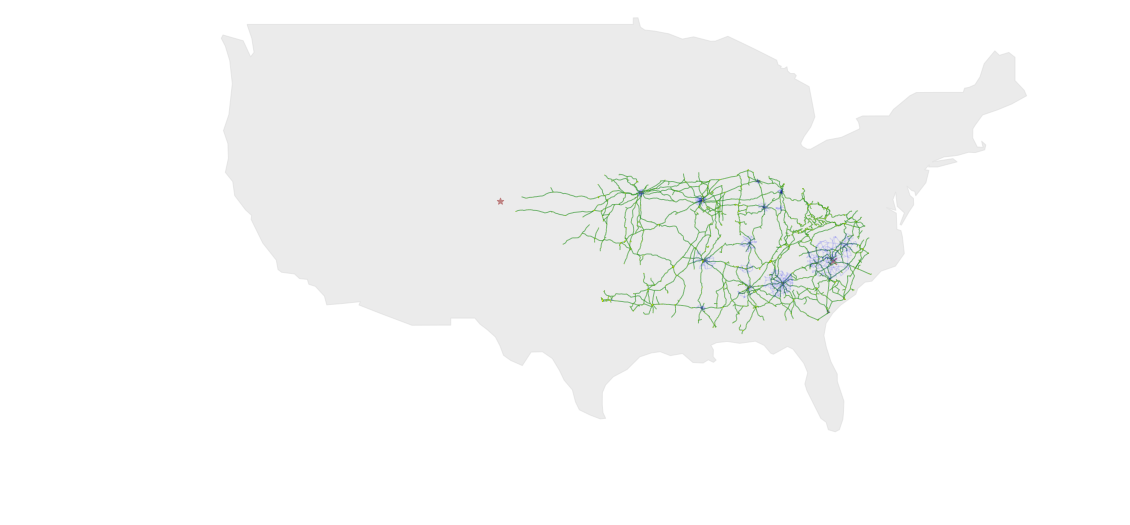

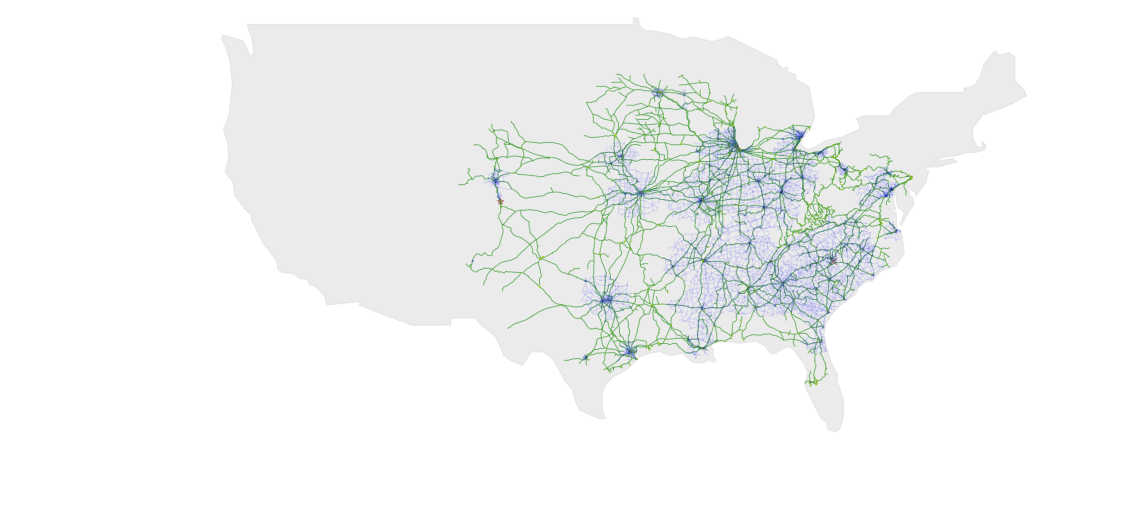

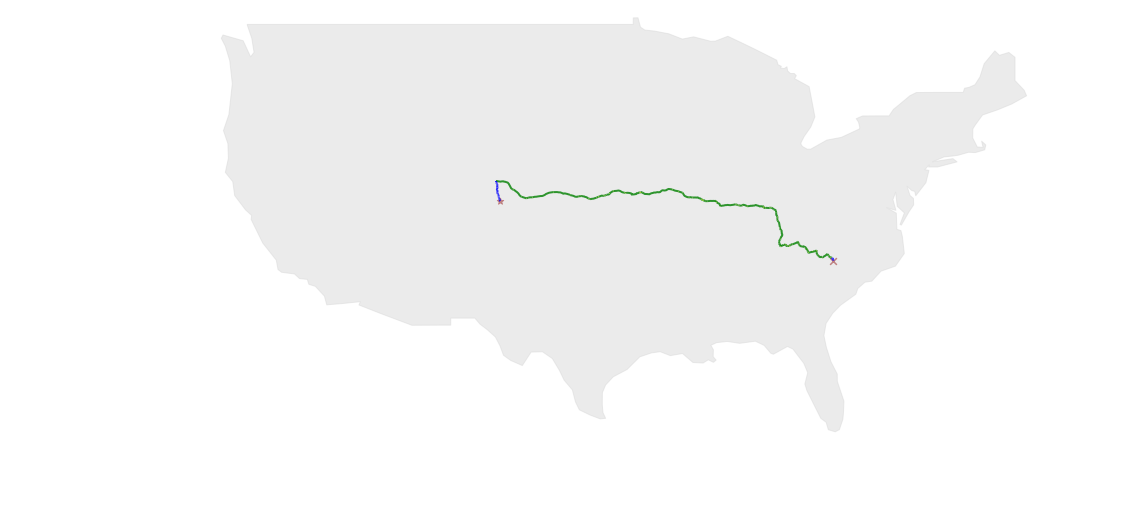

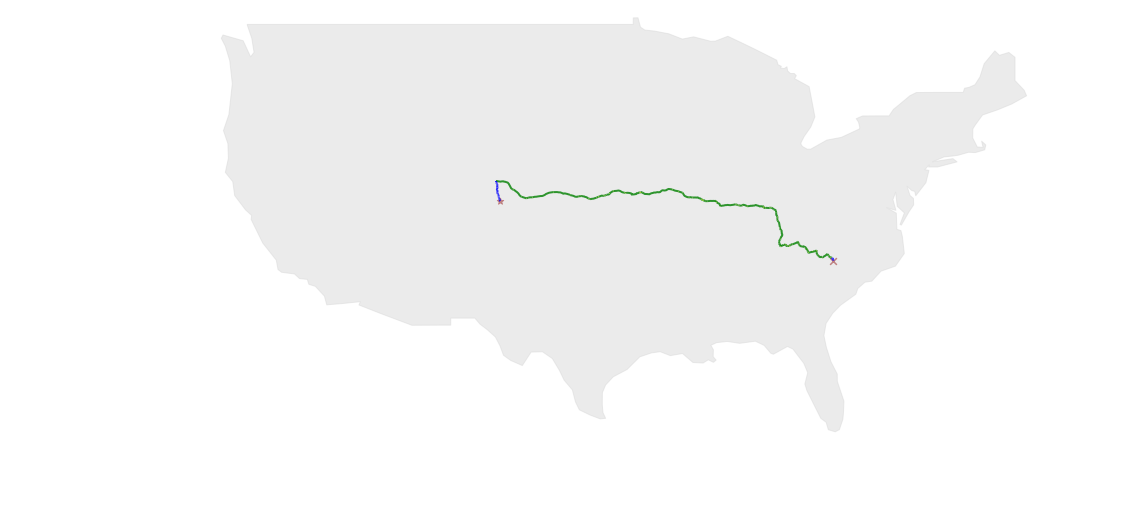

In [23]:
path, explored  = astar_path(Net.G_multimodal_u,
                                  node_orig, node_dest,
                                  heuristic=heuristic_func_co2,
                                  weight=target,
                                  capture_list=capture_list,
                            save=True) #range(100,30000,400)

In [ ]:
out = dijkstra(Net.G_multimodal_u, source=node_orig, weight_str=target, target=node_dest, save=True, capture_list=capture_list,)

In [ ]:
out = bidirectionnal_dijkstra(Net.G_multimodal_u, source=node_orig, target=node_dest, weight=target, save=True, capture_list=capture_list)